In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import matplotlib.patches as mpatches
from skimage.metrics import hausdorff_distance
from skimage.morphology import remove_small_objects, binary_erosion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

In [2]:
def get_boundary(mask):
    """Extracts the boundary of a binary mask."""
    mask = mask.astype(bool)
    return mask ^ binary_erosion(mask)

def get_points(mask):
    """Returns the coordinates of nonzero points in the mask."""
    return np.argwhere(mask)

def calHDPercentile(mask1, mask2, filename="hd_percentiles.dat"):
    # Get boundaries
    boundary1 = get_boundary(mask1)
    boundary2 = get_boundary(mask2)
    points1 = get_points(boundary1)
    points2 = get_points(boundary2)

    percentiles = np.arange(0, 101, 5)
    if points1.size == 0 or points2.size == 0:
        np.savetxt(filename, np.column_stack((percentiles, np.full_like(percentiles, np.nan, dtype=float))),
                   fmt="%.1f %.6f", header="percentile hd")
        return

    tree2 = cKDTree(points2)
    dists1, _ = tree2.query(points1, k=1)
    tree1 = cKDTree(points1)
    dists2, _ = tree1.query(points2, k=1)

    hd_values = [max(np.percentile(dists1, p), np.percentile(dists2, p)) for p in percentiles]
    np.savetxt(filename, np.column_stack((percentiles, hd_values)), fmt="%.1f %.6f", header="percentile hd")

# Example usage for multi-class masks:
def saveHDPercentile(gt_mask, pred_mask, class_labels, prefix="HD"):
    """
    gt_mask: ground truth mask (2D numpy array, integer class labels)
    pred_mask: predicted mask (2D numpy array, integer class labels)
    class_labels: list or array of class label values, e.g. [0, 100, 255]
    prefix: prefix for output files
    """
    for cls in class_labels:
        gt_bin = (gt_mask == cls).astype(np.uint8)
        pred_bin = (pred_mask == cls).astype(np.uint8)
        filename = f"{prefix}_class{cls}.dat"
        calHDPercentile(gt_bin, pred_bin, filename)
        print(f"Saved HD percentiles for class {cls} to {filename}")
    
     # Overall (all foreground as one class, i.e., not background)
    # If background is 0, foreground is everything else
    gt_foreground = (gt_mask != 0).astype(np.uint8)
    pred_foreground = (pred_mask != 0).astype(np.uint8)
    filename = f"{prefix}_overall.dat"
    calHDPercentile(gt_foreground, pred_foreground, filename)
    print(f"Saved HD percentiles for overall (all foreground) to {filename}")

In [3]:
def hd95(mask1, mask2):
    """
    Computes the 95th percentile Hausdorff Distance (HD95) between two binary masks.
    Parameters:
        mask1, mask2: 2D numpy arrays (binary masks)
    Returns:
        hd95: float (the HD95 value)
    """
    # Get boundaries
    boundary1 = get_boundary(mask1)
    boundary2 = get_boundary(mask2)
    points1 = get_points(boundary1)
    points2 = get_points(boundary2)

    # Handle empty boundaries
    if points1.size == 0 or points2.size == 0:
        return np.nan

    # Compute distances from boundary1 to boundary2
    tree2 = cKDTree(points2)
    dists1, _ = tree2.query(points1, k=1)
    # Compute distances from boundary2 to boundary1
    tree1 = cKDTree(points1)
    dists2, _ = tree1.query(points2, k=1)

    # Take the 95th percentile in both directions
    hd95_1 = np.percentile(dists1, 95)
    hd95_2 = np.percentile(dists2, 95)
    return max(hd95_1, hd95_2)

def hausdorffDistance(gt_mask, pred_mask):
    """Compute the Hausdorff Distance between the boundaries of two binary masks."""
    # Extract contours
    
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)
    # Remove small objects in the contour (optional)
    # gt_contour = remove_small_objects(gt_mask.astype(bool), min_size=1000)
    # pred_contour = remove_small_objects(pred_mask.astype(bool), min_size=1000)
    gt_contour,  pred_contour =  gt_mask, pred_mask
    # Compute Hausdorff on contours
    return hausdorff_distance(gt_contour, pred_contour)

def calculate_metrics(gt_mask, pred_mask, class_labels, ignore_labels=(200, 150), min_size=1000):
    """Calculate metrics (IoU, Precision, Recall, F1, Hausdorff, HD95) for each class."""
    metrics = {}
    # valid_mask = (gt_mask != ignore_label)
    ignore_labels = set(ignore_labels)
    valid_mask = ~np.isin(gt_mask, list(ignore_labels))
    img_diag = np.sqrt(gt_mask.shape[0]**2 + gt_mask.shape[1]**2)

    for class_label in class_labels:
        # Mask out ignore regions
        gt_class_mask = ((gt_mask == class_label) & valid_mask)
        pred_class_mask = ((pred_mask == class_label) & valid_mask)
        # Convert to uint8 for further processing
        gt_class_mask = gt_class_mask.astype(np.uint8)
        pred_class_mask = pred_class_mask.astype(np.uint8)

        # Metrics
        tp = np.sum((gt_class_mask == 1) & (pred_class_mask == 1))
        fp = np.sum((gt_class_mask == 0) & (pred_class_mask == 1))
        fn = np.sum((gt_class_mask == 1) & (pred_class_mask == 0))
        tn = np.sum((gt_class_mask == 0) & (pred_class_mask == 0))
        iou = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        f1_s = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
        accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) != 0 else 0.0

        # Hausdorff distances
        hd = hausdorffDistance(gt_class_mask, pred_class_mask)
        hd95_val = hd95(gt_class_mask, pred_class_mask)
        # hd95_val = hd95_boundary(gt_class_mask, pred_class_mask, min_size=min_size)

        metrics[class_label] = {
            'Accuracy': accuracy,
            'IoU (Jaccard)': iou,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_s,
            'Hausdorff Distance': hd,
            'HD95': hd95_val,
            'HD/Diag (%)': 100 * hd / img_diag if img_diag > 0 else np.nan,
            # 'HD95/Diag (%)': 100 * hd95_val / img_diag if img_diag > 0 else np.nan
        }
        
    # Overall metrics (excluding ignore label)
    gt_valid = gt_mask[valid_mask].flatten()
    pred_valid = pred_mask[valid_mask].flatten()    
    
    class_labels = [0, 100, 255]
    # Compute multiclass metrics    
    overall_accuracy = accuracy_score(gt_valid, pred_valid)
    overall_precision = precision_score(gt_valid, pred_valid, average='macro', labels=class_labels, zero_division=0)
    overall_recall = recall_score(gt_valid, pred_valid, average='macro', labels=class_labels, zero_division=0)
    overall_f1 = f1_score(gt_valid, pred_valid, average='macro', labels=class_labels, zero_division=0)
    overall_iou = jaccard_score(gt_valid, pred_valid, average='macro', labels=class_labels, zero_division=0)

    overall_hd = np.mean([hausdorffDistance((gt_mask == c) & valid_mask, (pred_mask == c) & valid_mask) for c in class_labels])
    overall_hd95 = np.mean([hd95((gt_mask == c) & valid_mask, (pred_mask == c) & valid_mask) for c in class_labels])

    metrics['overall'] = {
        'Accuracy': overall_accuracy,
        'IoU (Jaccard)': overall_iou,
        'Precision': overall_precision,
        'Recall': overall_recall,
        'F1 Score': overall_f1,
        'Hausdorff Distance': overall_hd,
        'HD95': overall_hd95,
        'HD/Diag (%)': 100 * overall_hd95 / img_diag if img_diag > 0 else np.nan,
        }
    return metrics

In [4]:
def mask_to_coords(mask):
    # Returns a list of (x, y) coordinates where mask is True
    return np.column_stack(np.where(mask))

def plot_boundaries(gt_mask, pred_mask, class_label, ignore_labels=(200,150), min_size=1000, thickness=2):
    """Visualize boundaries of GT and prediction for a given class."""
    # valid_mask = (gt_mask != ignore_label)
    ignore_labels = set(ignore_labels)
    valid_mask = ~np.isin(gt_mask, list(ignore_labels))
    
    gt_class = ((gt_mask == class_label) & valid_mask)
    pred_class = ((pred_mask == class_label) & valid_mask)
    gt_class = remove_small_objects(gt_class, min_size=min_size)
    pred_class = remove_small_objects(pred_class, min_size=min_size)    
    gt_contour = gt_class ^ binary_erosion(gt_class)
    pred_contour = pred_class ^ binary_erosion(pred_class)
    
    gt_coords = mask_to_coords(gt_contour)
    pred_coords = mask_to_coords(pred_contour)
    
    # Save to CSV or TXT
    np.savetxt(f'gt_contour_{class_label}.txt', gt_coords, fmt='%d', delimiter=' ')
    np.savetxt(f'pred_contour_{class_label}.txt', pred_coords, fmt='%d', delimiter=' ')
   
    # Light gray background
    # colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # Matplotlib uses [0,1] for RGB
    # overlay = np.ones((gt_class.shape[0], gt_class.shape[1], 4)) * 0.9
    # overlay[gt_contour, :3] = colors[0]
    # overlay[gt_contour, 3] = 1  # 50% alpha
    # overlay[pred_contour, :3] = colors[2]
    # overlay[pred_contour, 3] = 1  # 50% 
    overlay = np.ones((*gt_class.shape, 3), dtype=np.uint8) * 200
    overlay[gt_contour, 0] = 255  # Red channel for GT
    overlay[gt_contour, 1] = 0
    overlay[gt_contour, 2] = 0
    overlay[pred_contour, 0] = 0
    overlay[pred_contour, 1] = 0
    overlay[pred_contour, 2] = 150  # Blue channel for Prediction

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay, alpha=1, cmap='gray')
    red_patch = mpatches.Patch(color='red', label='Ground Truth')
    blue_patch = mpatches.Patch(color='blue', label='Predicted')
    plt.legend(handles=[red_patch, blue_patch], loc='lower left', frameon=True)
    plt.axis('off')
    plt.savefig(f"BC_{class_label}.png", bbox_inches='tight', dpi=300)
    plt.title(f"Boundaries for class {class_label}")
    plt.show()

def compute_and_plot_confusion_matrices(gt_mask, pred_mask, class_labels, ignore_label=(200,150)):
    gt = gt_mask.flatten()
    pred = pred_mask.flatten()
    # if ignore_label is not None:
    #     valid = gt != ignore_label
    #     gt = gt[valid]
    #     pred = pred[valid]
    if ignore_label is not None:
        # Use np.isin for multiple ignore labels
        valid = ~np.isin(gt, ignore_label)
        gt = gt[valid]
        pred = pred[valid]

    # Overall multiclass confusion matrix
    cm = confusion_matrix(gt, pred, labels=class_labels)
    print("Overall Confusion Matrix (rows: True, columns: Predicted):\n", cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig("cm_overall.png", bbox_inches='tight', dpi=300)
    plt.title('Overall Confusion Matrix')
    plt.show()

    # Per-class confusion matrices (standard layout)
    mcm = multilabel_confusion_matrix(gt, pred, labels=class_labels)
    for idx, label in enumerate(class_labels):
        tn, fp, fn, tp = mcm[idx].ravel()
        mat = np.array([[tp, fp],
                        [fn, tn]])
        print(f"\nConfusion Matrix for class {label} (One-vs-Rest):")
        print(mat)
        plt.figure()
        cell_labels = np.array([['TP', 'FP'],
                                ['FN', 'TN']])
        annot = np.empty_like(mat, dtype=object)
        for i in range(2):
            for j in range(2):
                annot[i, j] = f"{cell_labels[i, j]}\n{mat[i, j]}"
        sns.heatmap(mat, annot=annot, fmt='', cmap='Oranges',
                    xticklabels=['Positive', 'Negative'],
                    yticklabels=['Positive', 'Negative'])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.savefig(f"cm_cls_{label}.png", bbox_inches='tight', dpi=300)
        plt.title(f'One-vs-Rest Confusion Matrix for class {label}')
        plt.show()



GT labels:  [  0 100 150 255]
Pred labels before:  [  0 100 200]
Pred labels after:  [  0 100 255]


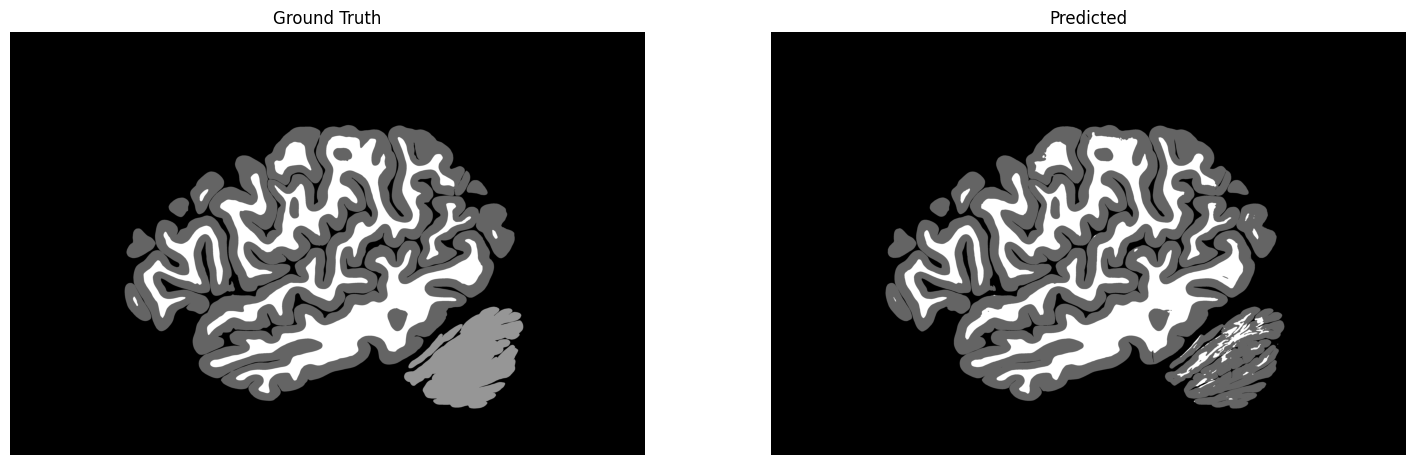

In [5]:
# Load masks (ensure correct paths and classes)
# gt_mask = cv2.imread('GT/PE-2021-00981-H_00_s0920_BF_Raw_Flat_v001_wm_gm_mask.png', cv2.IMREAD_GRAYSCALE)
# pred_mask = cv2.imread('Pred/Kmulticlass.png', cv2.IMREAD_GRAYSCALE)

# gt_mask = cv2.imread('/mnt/g/ThesisDocumentMine/Convention/latex/Images/Metrics/GT/Result4.png', cv2.IMREAD_GRAYSCALE)
# pred_mask = cv2.imread('Pred/Morph/multiMask4.png', cv2.IMREAD_GRAYSCALE)
# pred_mask = cv2.imread('/mnt/g/ThesisDocumentMine/Convention/latex/Images/Metrics/Pred/multiMask4.png', cv2.IMREAD_GRAYSCALE)
# pred_mask = cv2.imread('/mnt/g/ThesisDocumentMine/Convention/latex/Images/Metrics/DP/128/0.5/morphed/morph4.png', cv2.IMREAD_GRAYSCALE)


gt_mask = cv2.imread('/mnt/g/Data/myGT/GT/PE-2021-00981-H_00_s0340_BF_Mask_GT_v000.png', cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.imread('/mnt/d/Results/wd1e_6/random/256/20k/output/nHuman/PE-2021-00981-H_00_s0340_BF_Raw_Registered_Flat_v000.png', cv2.IMREAD_GRAYSCALE)


print('GT labels: ', np.unique(gt_mask))
print('Pred labels before: ', np.unique(pred_mask))
gt_mask[gt_mask == 7] = 0
gt_mask[gt_mask == 13] = 0
pred_mask[pred_mask == 200] = 255
print('Pred labels after: ', np.unique(pred_mask))
# Visualize masks   
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')
plt.title('Predicted')
plt.show()

In [6]:
# saveHDPercentile(gt_mask, pred_mask, class_labels=[0, 100, 255], prefix="hdpercentile")

In [7]:
# List of unique class labels in the segmentation (modify as needed)
class_labels = [0, 100, 255]  # Example: [0 = background, 100 = class 1, 255 = class 2]
# Calculate metrics
metrics = calculate_metrics(gt_mask, pred_mask, class_labels, ignore_labels=(200,150), min_size=1000)
# Print metrics
for class_label, class_metrics in metrics.items():
    print(f"Class {class_label}:")
    for metric_name, value in class_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class 0:
  Accuracy: 0.9975
  IoU (Jaccard): 0.9966
  Precision: 0.9985
  Recall: 0.9981
  F1 Score: 0.9983
  Hausdorff Distance: 117.3371
  HD95: 3.0000
  HD/Diag (%): 1.7842

Class 100:
  Accuracy: 0.9937
  IoU (Jaccard): 0.9639
  Precision: 0.9846
  Recall: 0.9786
  F1 Score: 0.9816
  Hausdorff Distance: 769.9688
  HD95: 13.1529
  HD/Diag (%): 11.7078

Class 255:
  Accuracy: 0.9962
  IoU (Jaccard): 0.9504
  Precision: 0.9658
  Recall: 0.9836
  F1 Score: 0.9746
  Hausdorff Distance: 546.2106
  HD95: 10.1980
  HD/Diag (%): 8.3055

Class overall:
  Accuracy: 0.9936
  IoU (Jaccard): 0.9703
  Precision: 0.9830
  Recall: 0.9868
  F1 Score: 0.9848
  Hausdorff Distance: 477.8388
  HD95: 8.7837
  HD/Diag (%): 0.1336



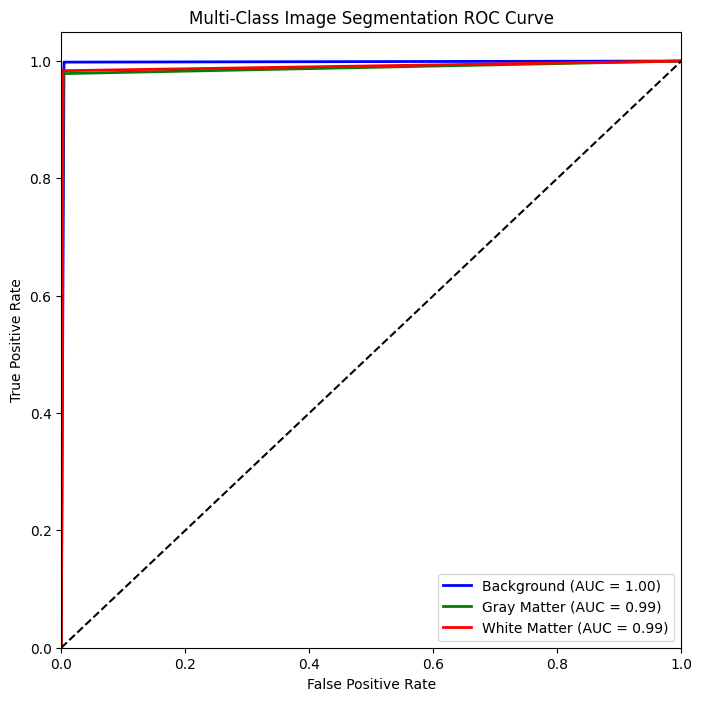

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Check that the images have the same shape
assert gt_mask.shape == pred_mask.shape, "Ground truth and predicted images must have the same shape."
ignore_labels = (150, 200)
ignore_labels = set(ignore_labels)
valid_mask = ~np.isin(gt_mask, list(ignore_labels))
# Flatten the images for easier processing
gt_image_flat = gt_mask.flatten()
pred_image_flat = pred_mask.flatten()
gt_image_flat[~valid_mask.flatten()] = 0
pred_image_flat[~valid_mask.flatten()] = 0
# Binarize the ground truth labels for multi-class (0, 100, 200)
lb = LabelBinarizer()
lb.fit([0, 100, 255])  # Fit the binarizer to the possible class labels
gt_image_bin = lb.transform(gt_image_flat)
pred_image_bin = lb.transform(pred_image_flat)

# Initialize the plot
plt.figure(figsize=(8, 8))# Define colors for each class
colors = ['blue', 'green', 'red']
class_names = ['Background', 'Gray Matter', 'White Matter']
classes = [0, 100, 255]

# Compute ROC curve and AUC for each class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(gt_image_bin[:, i], pred_image_bin[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each class
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot the random classifier line (diagonal line)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Image Segmentation ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

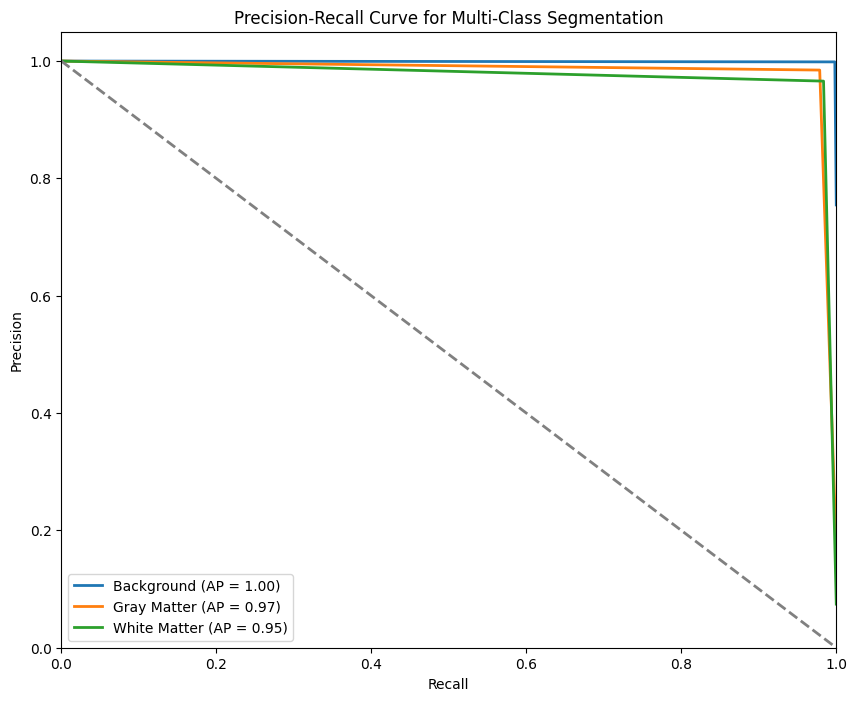

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(classes):
    # Compute Precision and Recall for the current class
    precision, recall, _ = precision_recall_curve(gt_image_bin[:, i], pred_image_bin[:, i])
    average_precision = average_precision_score(gt_image_bin[:, i], pred_image_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {average_precision:.2f})')

# Plot random classifier baseline (diagonal line)
plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Segmentation')
plt.legend(loc='lower left')
plt.show()

In [10]:
# compute_and_plot_confusion_matrices(gt_mask, pred_mask, class_labels, ignore_label=(200,150))

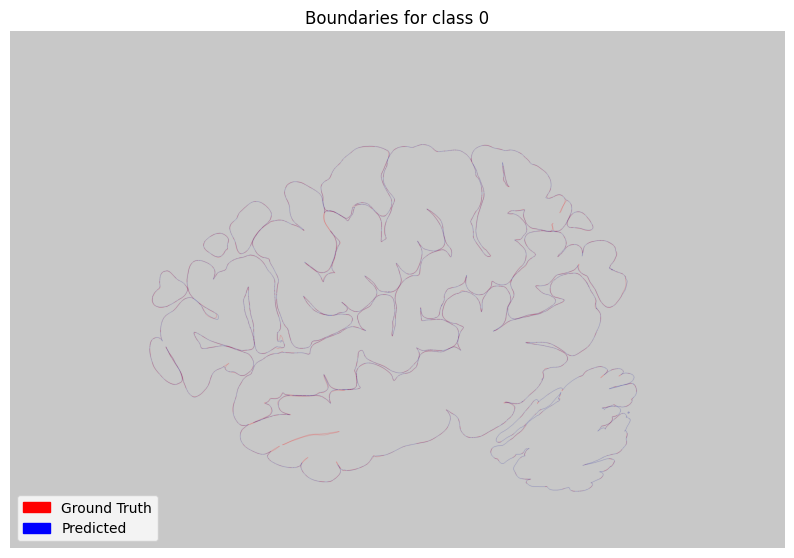

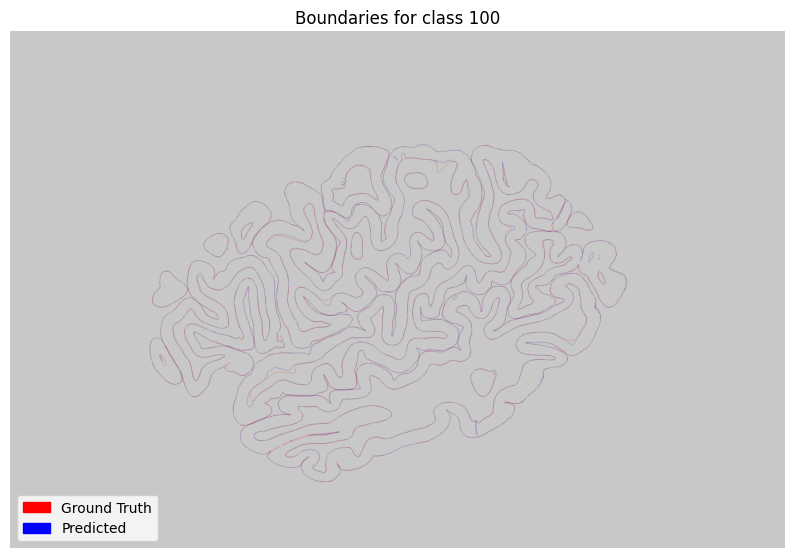

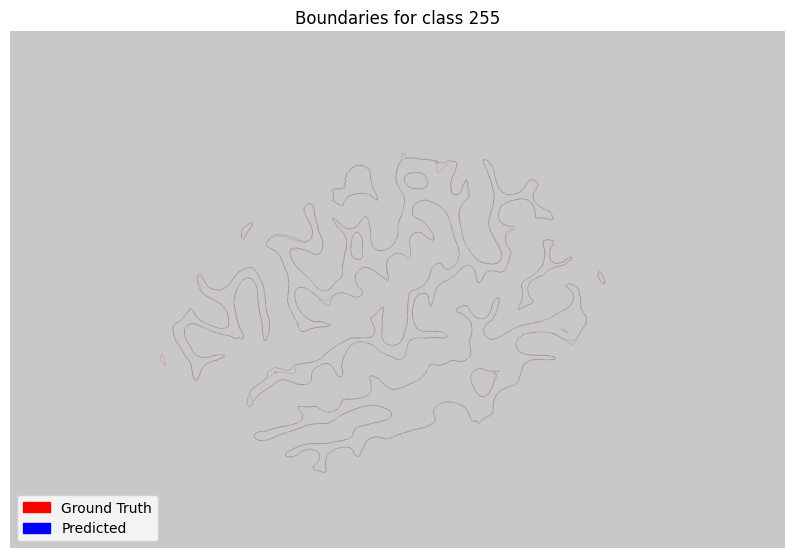

In [11]:
# Optional: visualize boundaries for each class
for class_label in class_labels:
    plot_boundaries(gt_mask, pred_mask, class_label, ignore_labels=(200,150), min_size=1000)

In [12]:
# def plot_per_class_confusion_scatter(gt_mask, pred_mask, class_labels, ignore_label=(200,150), class_colors=None):
#     """
#     For each class, plot a 2x2 confusion matrix (TP, FP, FN, TN) 
#     with actual pixel locations scattered in each cell.
#     """
#     h, w = gt_mask.shape
#     gt = gt_mask.flatten()
#     pred = pred_mask.flatten()
#     if ignore_label is not None:
#         valid = ~np.isin(gt, ignore_label)
#         gt = gt[valid]
#         pred = pred[valid]
#         flat_indices = np.arange(h*w)[valid]
#     else:
#         flat_indices = np.arange(h*w)
    
#     # Prepare coordinates for all valid pixels
#     coords = np.column_stack(np.unravel_index(flat_indices, (h, w)))
#     # Default colors if not provided
#     if class_colors is None:
#         cmap = plt.colormaps.get_cmap('tab10')
#         class_colors = [cmap(i) for i in range(len(class_labels))]
    
#     mcm = multilabel_confusion_matrix(gt, pred, labels=class_labels)
#     for idx, label in enumerate(class_labels):
#         # Find indices for TP, FP, FN, TN
#         true = (gt == label)
#         pred_ = (pred == label)
#         TP = np.where(true & pred_)[0]
#         FP = np.where(~true & pred_)[0]
#         FN = np.where(true & ~pred_)[0]
#         TN = np.where(~true & ~pred_)[0]

#         # Prepare scatter data for each cell
#         scatter_dict = {
#             'TP': coords[TP],
#             'FP': coords[FP],
#             'FN': coords[FN],
#             'TN': coords[TN],
#         }
#         cell_labels = np.array([['TP', 'FP'], ['FN', 'TN']])
#         cell_keys = np.array([['TP', 'FP'], ['FN', 'TN']])

#         fig, axarr = plt.subplots(2, 2, figsize=(8, 8))
#         for i in range(2):
#             for j in range(2):
#                 key = cell_keys[i, j]
#                 ax = axarr[i, j]
#                 ax.set_title(cell_labels[i, j])
#                 ax.set_xlim([0, w])
#                 ax.set_ylim([h, 0])  # image coordinates: y=0 at top
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 if scatter_dict[key].shape[0] > 0:
#                     ax.scatter(
#                         scatter_dict[key][:, 1],  # x
#                         scatter_dict[key][:, 0],  # y
#                         s=5,
#                         color=class_colors[idx],
#                         alpha=0.7,
#                         label=f"{label} ({key})"
#                     )
#                 # ax.legend(loc='upper right', fontsize=8)
#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.savefig(f"Class_{label}.png", bbox_inches='tight', dpi=300)
#         # plt.suptitle(f"Class {label} ({idx}) Confusion Matrix Scatter")
#         plt.show()

    
# plot_per_class_confusion_scatter(gt_mask, pred_mask, class_labels=[0, 100, 255], ignore_label=(200,150))

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch

# def plot_combined_confusion_scatter(gt_mask, pred_mask, class_labels, ignore_label=(200,150), class_colors=None):
#     h, w = gt_mask.shape
#     gt = gt_mask.flatten()
#     pred = pred_mask.flatten()

#     if ignore_label is not None:
#         ignore_label = np.atleast_1d(ignore_label)
#         valid = ~np.isin(gt, ignore_label)
#         gt = gt[valid]
#         pred = pred[valid]
#         flat_indices = np.arange(h * w)[valid]
#     else:
#         flat_indices = np.arange(h * w)

#     coords = np.column_stack(np.unravel_index(flat_indices, (h, w)))

#     # Default colors
#     if class_colors is None:
#         cmap = plt.colormaps.get_cmap('tab10')
#         class_colors = {label: cmap(i) for i, label in enumerate(class_labels)}

#     # Optional: readable names for legend
#     class_names = {
#         0: "Background",
#         100: "Gray Matter",
#         255: "White Matter"
#     }

#     # Initialize scatter data for TP, FP, FN, TN
#     scatter_dict = {'TP': [], 'FP': [], 'FN': [], 'TN': []}
#     color_dict = {'TP': [], 'FP': [], 'FN': [], 'TN': []}

#     for label in class_labels:
#         true = (gt == label)
#         pred_ = (pred == label)

#         TP = np.where(true & pred_)[0]
#         FP = np.where(~true & pred_)[0]
#         FN = np.where(true & ~pred_)[0]
#         TN = np.where(~true & ~pred_)[0]

#         for name, idxs in zip(['TP', 'FP', 'FN', 'TN'], [TP, FP, FN, TN]):
#             scatter_dict[name].append(coords[idxs])
#             color_dict[name].extend([class_colors[label]] * len(idxs))

#     # Stack all class data per quadrant
#     for key in scatter_dict:
#         if scatter_dict[key]:
#             scatter_dict[key] = np.vstack(scatter_dict[key])
#         else:
#             scatter_dict[key] = np.empty((0, 2))

#     # Plot 2×2 grid
#     fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
#     labels_grid = [['TP', 'FP'], ['FN', 'TN']]

#     for i in range(2):
#         for j in range(2):
#             key = labels_grid[i][j]
#             ax = axarr[i, j]
#             ax.set_title(key)
#             ax.set_xlim([0, w])
#             ax.set_ylim([h, 0])
#             ax.set_xticks([]); ax.set_yticks([])
#             if scatter_dict[key].shape[0] > 0:
#                 ax.scatter(
#                     scatter_dict[key][:, 1],
#                     scatter_dict[key][:, 0],
#                     s=2,
#                     alpha=0.6,
#                     color=color_dict[key]
#                 )

#     # Create legend
#     legend_elements = [
#         Patch(facecolor=class_colors[label], label=f"{label} - {class_names.get(label, 'Class')}")
#         for label in class_labels
#     ]
#     fig.legend(handles=legend_elements, title="Classes", loc="lower center", ncol=len(class_labels))

#     plt.suptitle("Combined Per-Class Confusion Matrix Scatter")
#     plt.tight_layout(rect=[0, 0.05, 1, 0.95])
#     plt.show()
    
# plot_combined_confusion_scatter(gt_mask, pred_mask, class_labels=[0,100,255], ignore_label=(200,150), class_colors=None)